# DAT-ATX-1 Capstone Project

#### Nikolaos Vergos, February 2016
<nvergos@gmail.com>

## 2b. Supervised Learning: Classification

### 0. Import libraries & packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1. Import dataset

In [3]:
#Reading the dataset in a dataframe using Pandas
df = pd.read_csv("../data/master.csv")  

#Print first observations
df.head() 

,Facility_ID,Restaurant_Name,Inspection_Date,Process_Description,Geocode,Street,City,Zip_Code,Score,Med_Income,Population,Home_Ownership,Latitude,Longitude
0,2801996,Mr. Gatti's #118,2015-12-23,Routine Inspection,"2121 W PARMER LN, AUSTIN, TX 78758",2121 W PARMER LN,AUSTIN,78758,94,42398,42977,0.309,30.415649,-97.697569
1,10385802,Subway,2015-12-23,Routine Inspection,"2501 W PARMER LN, AUSTIN, TX 78758",2501 W PARMER LN,AUSTIN,78758,98,42398,42977,0.309,30.418236,-97.702242
2,2802274,Baskin Robbins,2015-12-23,Routine Inspection,"12407 N MOPAC EXPY, AUSTIN, TX 78758",12407 N MOPAC EXPY,AUSTIN,78758,99,42398,42977,0.309,30.417462,-97.702844
3,10964220,JR's Tacos,2015-12-22,Routine Inspection,"1921 CEDAR BEND DR, AUSTIN, TX 78758",1921 CEDAR BEND DR,AUSTIN,78758,91,42398,42977,0.309,30.408322,-97.698243
4,10778546,Econo Lodge,2015-12-22,Routine Inspection,"9100 BURNET RD, AUSTIN, TX 78758",9100 BURNET RD,AUSTIN,78758,91,42398,42977,0.309,30.374790,-97.726417


Throughout the Machine Learning part of this project we will be using **scikit-learn**, an open source machine learning library for the Python programming language.

Recall our arbitrary division of the city into 5 "Areas" spanning 36 Zip Codes: Central, SE, NE, SW, NW

In [4]:
# Focus on the main part of the city

SE_zip = (78744, 78747, 78719, 78741)
Central_zip = (78701, 78702, 78703, 78705, 78721, 78723, 78712, 78751, 78756)
NE_zip = (78752, 78753, 78754)
NW_zip = (78757, 78758, 78727, 78722, 78729, 78717, 78750, 78759, 78726, 78730, 78731, 78732)
SW_zip = (78704, 78745, 78748, 78739, 78749, 78735, 78733, 78746)

ACL_zip = SE_zip + Central_zip + NE_zip + NW_zip + SW_zip
len(ACL_zip)

36

We won't need the numerical data here, so let's delete those columns to declutter the Notebook:

In [5]:
del df['Population']
del df['Med_Income']
del df['Home_Ownership']

Let us prepare our DataFrame for Binary Classification models by assigning those Areas, Letter Grades and Pass/Fail according to a restaurant's score (as discussed in the README file) as well as encoding dummy variables:

In [6]:
# City areas

# Assign Area to each Restaurant, given its Zip Code

mask_SE = df.Zip_Code.isin(SE_zip)
mask_Central = df.Zip_Code.isin(Central_zip)
mask_NE = df.Zip_Code.isin(NE_zip)
mask_NW = df.Zip_Code.isin(NW_zip)
mask_SW = df.Zip_Code.isin(SW_zip)

df['Area'] = 'Austin'
df.loc[mask_SE, 'Area'] = 'SE Austin'
df.loc[mask_Central, 'Area'] = 'Central Austin'
df.loc[mask_NE, 'Area'] = 'NE Austin'
df.loc[mask_NW, 'Area'] = 'NW Austin'
df.loc[mask_SW, 'Area'] = 'SW Austin'

In [7]:
# Assign Pass/Fail status and Letter Grades to each Restaurant

df['Status'] = 'Fail'
df['Letter_Grade'] = 'F'

mask_pass = df['Score'] >= 70

mask_A = df['Score'] >= 90
mask_B = (df['Score'] >= 80) & (df['Score'] < 90)
mask_C = (df['Score'] >= 70) & (df['Score'] < 80)

df.loc[mask_pass, 'Status'] = 'Pass'

df.loc[mask_A, 'Letter_Grade'] = 'A'
df.loc[mask_B, 'Letter_Grade'] = 'B'
df.loc[mask_C, 'Letter_Grade'] = 'C'

In [8]:
df.head(3)

,Facility_ID,Restaurant_Name,Inspection_Date,Process_Description,Geocode,Street,City,Zip_Code,Score,Latitude,Longitude,Area,Status,Letter_Grade
0,2801996,Mr. Gatti's #118,2015-12-23,Routine Inspection,"2121 W PARMER LN, AUSTIN, TX 78758",2121 W PARMER LN,AUSTIN,78758,94,30.415649,-97.697569,NW Austin,Pass,A
1,10385802,Subway,2015-12-23,Routine Inspection,"2501 W PARMER LN, AUSTIN, TX 78758",2501 W PARMER LN,AUSTIN,78758,98,30.418236,-97.702242,NW Austin,Pass,A
2,2802274,Baskin Robbins,2015-12-23,Routine Inspection,"12407 N MOPAC EXPY, AUSTIN, TX 78758",12407 N MOPAC EXPY,AUSTIN,78758,99,30.417462,-97.702844,NW Austin,Pass,A


In [9]:
# Assign Dummy Variables for Binary Classifiers

# create five dummy variables using get_dummies, then exclude the first dummy column
# Note that the Area_Central variable is redundant

area_dummies = pd.get_dummies(df.Area, prefix='Area').iloc[:, 1:]

# create two dummy variables using get_dummies, then exclude the first dummy column
# Note that the Outcome_Fail variable is redundant

outcome_dummies = pd.get_dummies(df.Status, prefix='Status').iloc[:, 1:]

# create four dummy variables using get_dummies, then exclude the first dummy column
# Note that the Grade_A variable is redundant

letter_dummies = pd.get_dummies(df.Letter_Grade, prefix='Grade').iloc[:, 1:]

Let us check those DataFrames before we merge them into df:

In [10]:
area_dummies.head()

,Area_NE Austin,Area_NW Austin,Area_SE Austin,Area_SW Austin
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [11]:
outcome_dummies.head()

,Status_Pass
0,1
1,1
2,1
3,1
4,1


In [12]:
letter_dummies.head()

,Grade_B,Grade_C,Grade_F
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


Let us now concatenate those created DataFrames, keeping a copy of the original DataFrame just in case:

In [13]:
# Concatenate

# concatenate the dummy variable columns onto the original DataFrame (axis=0 means rows, axis=1 means columns)

data = pd.concat([df, area_dummies, outcome_dummies, letter_dummies], axis=1)
data.head()

,Facility_ID,Restaurant_Name,Inspection_Date,Process_Description,Geocode,Street,City,Zip_Code,Score,Latitude,...,Status,Letter_Grade,Area_NE Austin,Area_NW Austin,Area_SE Austin,Area_SW Austin,Status_Pass,Grade_B,Grade_C,Grade_F
0,2801996,Mr. Gatti's #118,2015-12-23,Routine Inspection,"2121 W PARMER LN, AUSTIN, TX 78758",2121 W PARMER LN,AUSTIN,78758,94,30.415649,...,Pass,A,0,1,0,0,1,0,0,0
1,10385802,Subway,2015-12-23,Routine Inspection,"2501 W PARMER LN, AUSTIN, TX 78758",2501 W PARMER LN,AUSTIN,78758,98,30.418236,...,Pass,A,0,1,0,0,1,0,0,0
2,2802274,Baskin Robbins,2015-12-23,Routine Inspection,"12407 N MOPAC EXPY, AUSTIN, TX 78758",12407 N MOPAC EXPY,AUSTIN,78758,99,30.417462,...,Pass,A,0,1,0,0,1,0,0,0
3,10964220,JR's Tacos,2015-12-22,Routine Inspection,"1921 CEDAR BEND DR, AUSTIN, TX 78758",1921 CEDAR BEND DR,AUSTIN,78758,91,30.408322,...,Pass,A,0,1,0,0,1,0,0,0
4,10778546,Econo Lodge,2015-12-22,Routine Inspection,"9100 BURNET RD, AUSTIN, TX 78758",9100 BURNET RD,AUSTIN,78758,91,30.374790,...,Pass,A,0,1,0,0,1,0,0,0


With 22 columns, the DataFrame has already become very hard to visualize, therefore we need to be very careful with our operations from now on.

### Logistic Regression

We will at first present an ill-fated approach in order to illustrate the workings of the logistic regression algorithm on our dataset as well as to discuss the evident class imbalance problem and attempt some techniques to mitigate its effects. A naive first approach was to use some of the features in order to predict whether a restaurant will pass the Health Inspection (Score > 69) or not.

The issue that makes this problem almost impossible to deal with:

In [14]:
num_pass = data[data["Status"]=='Pass'].count()
num_fail = data[data["Status"]=='Fail'].count()

In [15]:
print "Passing Inspections = {0}".format(num_pass[0])
print "Failing Inspections = {0}".format(num_fail[0])

Passing Inspections = 15936
Failing Inspections = 177


In a sum of 15936 rows, we have 99% passing restaurants (that have scored 70 or higher) and only 1% failing restaurants (that have scored 69 or lower). This is the **Class Imbalance** problem.

The approaches for addressing this are:
* **Sampling based** : By **oversampling** the minority class, it has more effect on the machine learning algorithm, or by **undersampling** majority class so it has less effect on the machine learning algorithm.
* **Cost function based approaches** : Make it more 'costly' for the learning algorithm to make mistakes in the minority class. This is done by tweaking the **cost function**.

I will try both approaches, starting from the latter: **scikit-learn** *Logistic Regression* model has the attribute *class_weight* that takes the default value *None* but can optionally take the value *balanced*. 

From the documentation: *"The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified."*

Let us start by trying to predict whether a restaurant will pass or fail inspection given the part of town (area) it is at:

In [16]:
from sklearn import linear_model
logm = linear_model.LogisticRegression(class_weight='balanced')

feature_cols = ['Area_NE Austin', 'Area_NW Austin', 'Area_SE Austin', 'Area_SW Austin']

X = data[ feature_cols ].values
y = data['Status_Pass'].values

In [17]:
# Check the shapes of the X and y vectors:

print X.shape
print y.shape

(16113, 4)
(16113,)


In [18]:
logm.fit(X,y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [19]:
print logm.predict(X)           # The array of our model's predictions for each area
print logm.classes_             # 0: Fail, 1: Pass
print logm.predict_proba(X)     # Probabilities for each entry to be assigned a "Fail" or a "Pass"

[ 1.  1.  1. ...,  0.  0.  0.]
[ 0.  1.]
[[ 0.41056793  0.58943207]
 [ 0.41056793  0.58943207]
 [ 0.41056793  0.58943207]
 ..., 
 [ 0.55157616  0.44842384]
 [ 0.55157616  0.44842384]
 [ 0.55157616  0.44842384]]


In [20]:
logm.score(X, y)

0.55824489542605349

Our classifier score is barely better than a coin toss. It seems we will have to improve our approach.

In [21]:
# examine the coefficients
pd.DataFrame(zip(data[feature_cols], np.transpose(logm.coef_)))

,0,1
0,Area_NE Austin,[0.165347643264]
1,Area_NW Austin,[0.568659146497]
2,Area_SE Austin,[-0.3470889829]
3,Area_SW Austin,[0.345019569204]


The coefficients above aren't necessarily significant but they show associations with increased/decreased likelihood of passing the health inspection set. As a matter of fact, a restaurant being located in Northwest Austin is more likely to pass the test whereas a restaurant in Southeast Austin is less likely to do so.

The real test of a good model is to train the model on a training set and then test it with data that it has not fitted. Here’s where the rubber meets the road.

In [22]:
from sklearn import cross_validation

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.8)

In [23]:
logm.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [24]:
# predict class labels for the test set
predicted = logm.predict(X_test)

print predicted

# generate class probabilities
probs = logm.predict_proba(X_test)

print probs

[ 1.  1.  1. ...,  1.  0.  1.]
[[ 0.42271349  0.57728651]
 [ 0.42271349  0.57728651]
 [ 0.42271349  0.57728651]
 ..., 
 [ 0.42271349  0.57728651]
 [ 0.55507747  0.44492253]
 [ 0.43280539  0.56719461]]


In [25]:
logm.score(X_test, y_test)

0.55848588271796462

k-fold Cross Validation has not really helped us improve the score of our classifier.

Even though we are far from creating a foolproof model, we can definitely discern some interesting trends.

In [26]:
# Evaluation Metrics

from sklearn import metrics

print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.558485882718
0.505858051723


The 0.506 ROC score is fairly low. It is telling us that our model is doing slightly better in predicting a restaurant's inspection outcome (pass/fail) than a coin toss (which would have a 0.5 probability)

In [27]:
# Confusion Matrix and Classification Report:

# Confusion Matrix

cm = metrics.confusion_matrix(y_test, logm.predict(X_test), labels=[1,0]) #labels = [1,0] will change the order: T,F

cm

array([[1781, 1404],
       [  19,   19]])

In [28]:
print metrics.confusion_matrix(y_test, predicted, labels=[1,0])
print metrics.classification_report(y_test, predicted,labels=[1,0])

[[1781 1404]
 [  19   19]]
             precision    recall  f1-score   support

          1       0.99      0.56      0.71      3185
          0       0.01      0.50      0.03        38

avg / total       0.98      0.56      0.71      3223



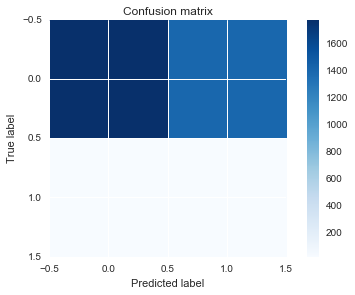

In [29]:
# Visualize Confusion Matrix:

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(cm)

There really isn't any reason for us to delve further into that model because the misclassification rate is really substantial and as we mentioned it's not really doing significantly better than a coin toss.

Let us now quickly approach a different strategy to mitigate the results of class imbalance: oversampling the minority class (failing restaurants)

In [30]:
#Grab DataFramea rows where column has certain values

value_list_f = ['Fail']
failures = data[data.Status.isin(value_list_f)]

value_list_p = ['Pass']
passes = data[data.Status.isin(value_list_p)]

In [31]:
# Let us pick two random samples of 100 rows each from the "failures" and "passes" dataframes: 

rows_f = np.random.choice(failures.index.values, 100)
rows_p = np.random.choice(passes.index.values, 100)

In [32]:
# Convert to dataframes:

sampled_f = failures.ix[rows_f]
sampled_p = passes.ix[rows_p]

In [33]:
# Concatenate into "training" dataframe:

training_df = pd.concat([sampled_p, sampled_f], axis=0)
print "The training DataFrame comprises {0} rows".format(len(training_df))

The training DataFrame comprises 200 rows


In [34]:
# Train our logistic regression model on this data:

logm = linear_model.LogisticRegression() # We don't need balanced class weights anymore
 
feature_cols = ['Area_NE Austin', 'Area_NW Austin', 'Area_SE Austin', 'Area_SW Austin']

X_tr = training_df[ feature_cols ].values
y_tr = training_df['Status_Pass'].values

logm.fit(X_tr, y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
print "The model's score on the training data is {0}%".format(logm.score(X_tr, y_tr)*100)

The model's score on the training data is 62.0%


This doesn't sound very promising. Regardless, let us construct the testing DataFrame (comprising all rows that aren't already seen by the model)

In [37]:
# Create a DataFrame with all rows that are in data but NOT in training_df:

df1 = data
df2 = training_df

common_cols = list(set(df1.columns) & set(df2.columns))

testing_df = pd.merge(df1,df2,on=common_cols,how="outer",indicator=True)

testing_df = testing_df.loc[testing_df['_merge'] == 'left_only']

In [38]:
X_ts = testing_df[ feature_cols ].values
y_ts = testing_df['Status_Pass'].values

In [39]:
# Model Validation:

# predict class labels for the test set
predicted = logm.predict(X_ts)

# generate class probabilities
probs = logm.predict_proba(X_ts)

# Evaluation Metrics:

print metrics.accuracy_score(y_ts, predicted)
print metrics.roc_auc_score(y_ts, probs[:, 1])

0.637721169532
0.540206009614


The results are no better than before, and possibly more disappointing. It seems that the part of town a restaurant is located in is a terrible predictor of its Health Inspection broad outcome. (Pass/Fail)

From now on I am changing my approach to something more drastic. Instead of aiming to classify health inspection outcomes as "Passes" or "Fails", I will implement a different kind of classification: A resulting letter grade of "A" (which implies a Health Inspection score of 90 or higher) vs. everything else (Scores 89 and below)

Before throwing my hands up in the air with the use of Area as input features for my models, I will try once more:

In [40]:
num_A = data[data["Letter_Grade"]=='A'].count()
num_other = data[data["Letter_Grade"]!='A'].count()

In [41]:
print "Pristine Restaurants (90 or above) = {0}".format(num_A[0])
print "Restaurants scoring 89 or below = {0}".format(num_other[0])

Pristine Restaurants (90 or above) = 10091
Restaurants scoring 89 or below = 6022


There is a much nicer distribution between the classes now! Let us construct two new dummy variables, one for "Pristine" restaurants (the same ones obtaining a grade "A", which has been the redundant dummy variable in my previous treatment) and one for everything else:

In [42]:
# I need the "Grade_A" column:

def pristine(x):
    if x >= 90:
        return 1
    else:
        return 0

In [43]:
data['Pristine'] = data['Score'].apply(pristine)
data.head(2)

,Facility_ID,Restaurant_Name,Inspection_Date,Process_Description,Geocode,Street,City,Zip_Code,Score,Latitude,...,Letter_Grade,Area_NE Austin,Area_NW Austin,Area_SE Austin,Area_SW Austin,Status_Pass,Grade_B,Grade_C,Grade_F,Pristine
0,2801996,Mr. Gatti's #118,2015-12-23,Routine Inspection,"2121 W PARMER LN, AUSTIN, TX 78758",2121 W PARMER LN,AUSTIN,78758,94,30.415649,...,A,0,1,0,0,1,0,0,0,1
1,10385802,Subway,2015-12-23,Routine Inspection,"2501 W PARMER LN, AUSTIN, TX 78758",2501 W PARMER LN,AUSTIN,78758,98,30.418236,...,A,0,1,0,0,1,0,0,0,1


Let us save this DataFrame as a csv file because we are going to use it again in the next Notebook (Text mining):

In [44]:
data.to_csv('../data/data.csv', index=False)

In [45]:
# Off to modeling:

logm = linear_model.LogisticRegression()

feature_cols = ['Area_NE Austin', 'Area_NW Austin', 'Area_SE Austin', 'Area_SW Austin']

X = data[ feature_cols ].values
y = data['Pristine'].values

In [46]:
# Cross-validation:

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.75)

In [47]:
# Fitting the model:

logm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
# Model Validation:

# predict class labels for the test set
predicted = logm.predict(X_test)

# generate class probabilities
probs = logm.predict_proba(X_test)

# Evaluation Metrics:

print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.619508562919
0.554171998093


Even though our goal has changed (we are seeking to predict whether a restaurant will ace the health inspection) the results of our model are still disappointing. It is becoming more and more evident that Area isn't a good predictor.

Our final attempt will be to "strong-arm" our model by manually changing the logistic regression classification threshold from 0.5 to something much higher like 0.8

Hopefully this will eradicate some of the misclassifications. In order to manipulate our model like that, we will use *statsmodels* instead of scikit-learn: 

In [49]:
import statsmodels.api as sm

logit = sm.Logit(data['Pristine'], data[ feature_cols ])

In [50]:
# fit the model

model_result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.664674
         Iterations 4


In [51]:
predicted = model_result.predict(data[ feature_cols ])

In [52]:
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

for i in thresholds:
    predicted_choice = (predicted > i).astype(int)
    print "The number of restaurants predicted to pass inspection (grade A) with logistic threshold = {0} is {1}".\
    format(i, sum(predicted_choice) )

The number of restaurants predicted to pass inspection (grade A) with logistic threshold = 0.5 is 11442
The number of restaurants predicted to pass inspection (grade A) with logistic threshold = 0.6 is 8972
The number of restaurants predicted to pass inspection (grade A) with logistic threshold = 0.7 is 0
The number of restaurants predicted to pass inspection (grade A) with logistic threshold = 0.8 is 0
The number of restaurants predicted to pass inspection (grade A) with logistic threshold = 0.9 is 0


Raising the logistic regression classifier threshold to anything higher than 60% results in zero restaurants predicted to pass inspection with a grade "A", given the area.

In [53]:
print model_result.summary()

                           Logit Regression Results                           
Dep. Variable:               Pristine   No. Observations:                16113
Model:                          Logit   Df Residuals:                    16109
Method:                           MLE   Df Model:                            3
Date:                Mon, 15 Feb 2016   Pseudo R-squ.:               -0.005689
Time:                        16:23:23   Log-Likelihood:                -10710.
converged:                       True   LL-Null:                       -10649.
                                        LLR p-value:                     1.000
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Area_NE Austin     0.1944      0.055      3.502      0.000         0.086     0.303
Area_NW Austin     0.7522      0.031     24.043      0.000         0.691     0.814
Area_SE Austin     0.2305      0.059

We get a great overview of the coefficients of the model, how well those coefficients fit, the overall fit quality, and several other statistical measures.

The result object also lets us to isolate and inspect parts of the model output. The confidence interval gives an idea for how robust the coefficients of the model are. Once again, we might not be getting anything really important from this classifier, but we can definitely see the "trend" of restaurants being located in my ad hoc "Northwest Austin" area being more prone to do better.

In [54]:
# Odds ratio:

print np.exp(model_result.params)

Area_NE Austin    1.214527
Area_NW Austin    2.121756
Area_SE Austin    1.259259
Area_SW Austin    1.666667
dtype: float64


This tells us how a 1 unit increase or decrease in a variable affects the odds of scoring an "A". For example, we can expect the odds of scoring an "A" to increase by about 212% if the restaurant is located in Northwest Austin. However we should be really cautious and only perceive those odds ratios relative to each other.

#### Logistic Regression outcome:

Regardless of the model used, the overall prediction accuracy for the city is close to 60%, which is almost equal to random guessing and therefore implies that the area is probably not a useful factor.

The poor performance of this factor is likely due to the fact that each area is very large and consists of many diverse neighborhoods (zip codes), which means there is too much variation within each area.

### k - Nearest Neighbors Classification on average scores

The greatest plight of our DataFrame and our attempts to apply supervised learning techniques to predict the inspection score is the absence of continuous (or categorical) features **specific** to each restaurant. Let us attempt a different binary classifier, k Nearest Neighbors, for the case where our DataFrame comprises the averaged scores of each Zip Code. Again, we need to be overly cautious because we only have 35 rows now:

In [55]:
average_scores = data.groupby('Zip_Code').mean()
len(average_scores)

35

In [56]:
average_scores.head()

,Facility_ID,Score,Latitude,Longitude,Area_NE Austin,Area_NW Austin,Area_SE Austin,Area_SW Austin,Status_Pass,Grade_B,Grade_C,Grade_F,Pristine
Zip_Code,,,,,,,,,,,,,
78701,7394822.662348,87.714939,30.268113,-97.742015,0,0,0,0,0.983994,0.350610,0.153963,0.016006,0.479421
78702,7173129.697500,89.976250,30.263794,-97.718697,0,0,0,0,0.980000,0.282500,0.087500,0.020000,0.610000
78703,6246431.545220,90.149871,30.280433,-97.761260,0,0,0,0,1.000000,0.312661,0.093023,0.000000,0.594315
78704,7250249.096037,89.975610,30.244061,-97.764413,0,0,0,1,0.990854,0.304878,0.091463,0.009146,0.594512
78705,6567070.349493,92.064262,30.291497,-97.741109,0,0,0,0,0.988726,0.205186,0.068771,0.011274,0.714769


We will need to create another dummy column for "Pristine" since averaging removed the 1-0 dichotomy. We do get some interesting average scores for each zip code though.

In [57]:
def dummy_pristine(x):
    if x >= 0.50:
        return 1
    else:
        return 0
    
average_scores['Pristine_Dummy'] = average_scores['Pristine'].apply(dummy_pristine)
average_scores.head()

,Facility_ID,Score,Latitude,Longitude,Area_NE Austin,Area_NW Austin,Area_SE Austin,Area_SW Austin,Status_Pass,Grade_B,Grade_C,Grade_F,Pristine,Pristine_Dummy
Zip_Code,,,,,,,,,,,,,,
78701,7394822.662348,87.714939,30.268113,-97.742015,0,0,0,0,0.983994,0.350610,0.153963,0.016006,0.479421,0
78702,7173129.697500,89.976250,30.263794,-97.718697,0,0,0,0,0.980000,0.282500,0.087500,0.020000,0.610000,1
78703,6246431.545220,90.149871,30.280433,-97.761260,0,0,0,0,1.000000,0.312661,0.093023,0.000000,0.594315,1
78704,7250249.096037,89.975610,30.244061,-97.764413,0,0,0,1,0.990854,0.304878,0.091463,0.009146,0.594512,1
78705,6567070.349493,92.064262,30.291497,-97.741109,0,0,0,0,0.988726,0.205186,0.068771,0.011274,0.714769,1


In [58]:
from matplotlib.colors import ListedColormap
from sklearn import feature_selection
from sklearn.neighbors import KNeighborsClassifier as KNN

In [59]:
feature_cols = ['Area_NE Austin', 'Area_NW Austin', 'Area_SE Austin', 'Area_SW Austin']

X = average_scores[ feature_cols ].values
y = average_scores['Pristine_Dummy'].values

clf = KNN(3)
clf.fit(X, y)
print clf.score(X, y)

0.914285714286


A score of 91% on 35 rows of data isn't exciting; it is overfitting. Even though we only have few points, we can attempt train/test split and cross validation:

In [60]:
# Cross-validation:

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.8)

In [61]:
clf.fit(X_train, y_train)
print clf.score(X_test, y_test)

0.857142857143


Looks slightly better

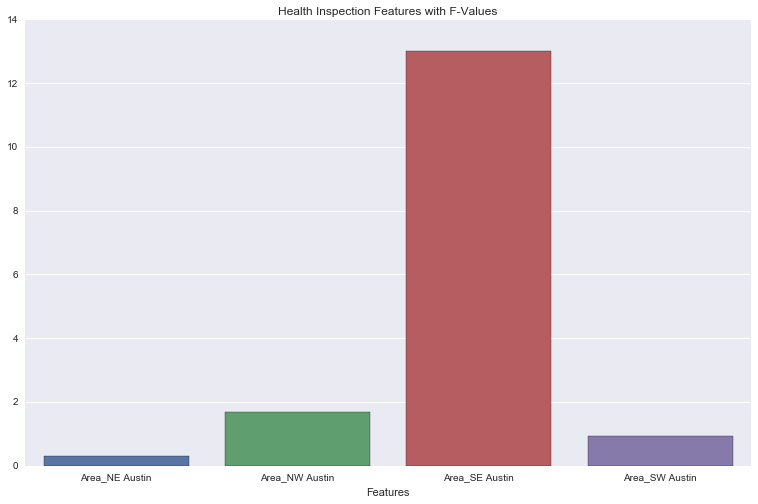

In [62]:
# Let's figure out what our most powerful features are.

F = feature_selection.f_classif(X, y)[0]
title = 'Health Inspection Features with F-Values'

plt.figure(figsize=(13, 8))
ax = sns.barplot(x=feature_cols,y=F)
ax.set_title(title)
ax.set(xlabel="Features");

The k Nearest Neighbors classifier yields another interesting feature: the importance of "Southeast Austin" in classifying a restaurant as "pristine" or not.

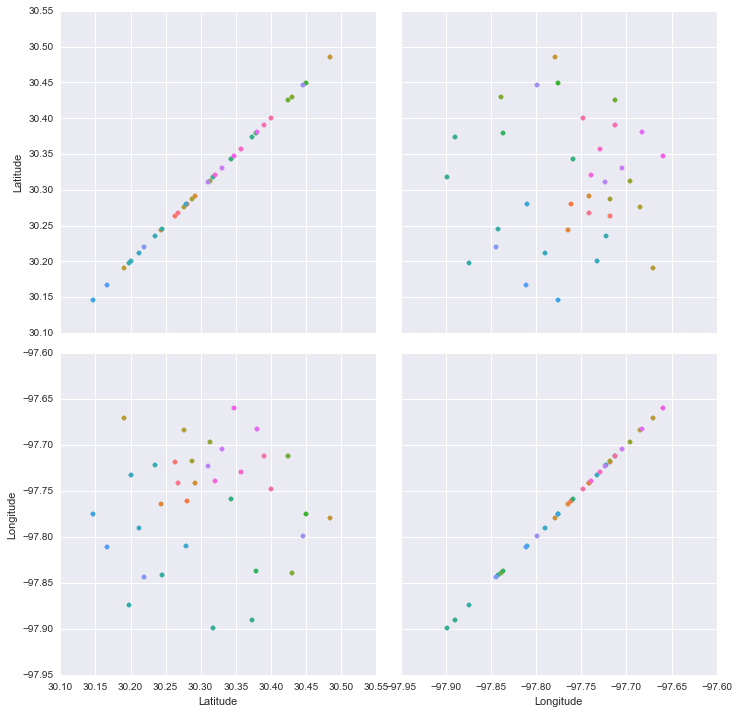

In [63]:
g = sns.PairGrid(average_scores, vars=["Latitude", "Longitude"],
                 hue="Pristine", aspect=1, size=5)
g.map(plt.scatter);

In [64]:
y = average_scores['Pristine']
a = list(y.unique())
a = [round(n, 1) for n in a]

In [65]:
average_scores['Round_Pristine'] = a

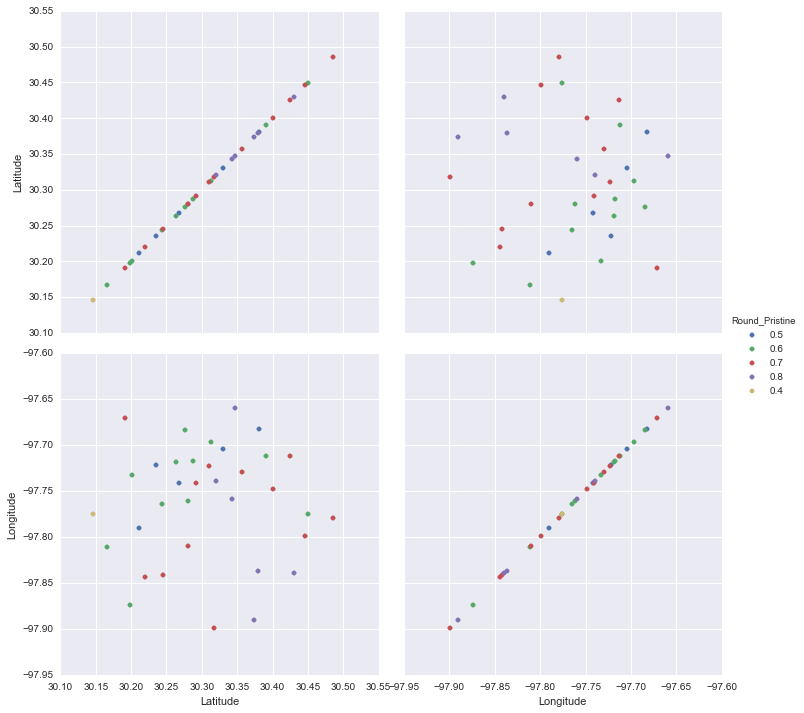

In [66]:
g = sns.PairGrid(average_scores, vars=["Latitude", "Longitude"],
                 hue="Round_Pristine", aspect=1, size=5)
g.map(plt.scatter);
g = g.add_legend()

We have plotted those averages on this longitude/latitude plane that resembles a map. The hue of the data points corresponds to "Pristine", which in our case is the fraction of restaurants that have been awarded a perfect score in each Zip Code.

In [67]:
r = set(a)
len(r) # The number of unique "Rounded Pristine" scores, we will use that to visualize decision boundaries:

5

#### Visualizing the decision boundaries

In [68]:
h = .02  # step size in the mesh

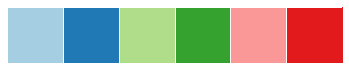

In [69]:
# Create color maps
col_map = sns.color_palette("Paired")
sns.palplot(col_map)
cmap_light = ListedColormap(['#A6CEE3', '#AFDD8A', '#FA9897'])
cmap_bold = ListedColormap(['#2078B4', '#35A12E', '#E31A1C'])

In [70]:
print a

[0.5, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.6, 0.6, 0.6, 0.8, 0.7, 0.6, 0.8, 0.8, 0.8, 0.7, 0.7, 0.6, 0.5, 0.6, 0.5, 0.7, 0.4, 0.6, 0.7, 0.7, 0.7, 0.5, 0.5, 0.8, 0.8, 0.7, 0.6, 0.7]


In [71]:
features = ['Latitude', 'Longitude']
X_ = average_scores[features].values

r =list(r)
y_ = [r.index(v) for v in a] # Encode the rounded scores to integers

In [72]:
print y_

[0, 2, 2, 2, 1, 1, 1, 2, 2, 2, 4, 1, 2, 4, 4, 4, 1, 1, 2, 0, 2, 0, 1, 3, 2, 1, 1, 1, 0, 0, 4, 4, 1, 2, 1]


In [73]:
clf = KNN(2, weights='uniform')
clf.fit(X_, y_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [74]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]*[y_min, y_max].
x_min, x_max = X_[:, 0].min() - 1, X_[:, 0].max() + 1
y_min, y_max = X_[:, 1].min() - 1, X_[:, 1].max() + 1

In [75]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

In [76]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)

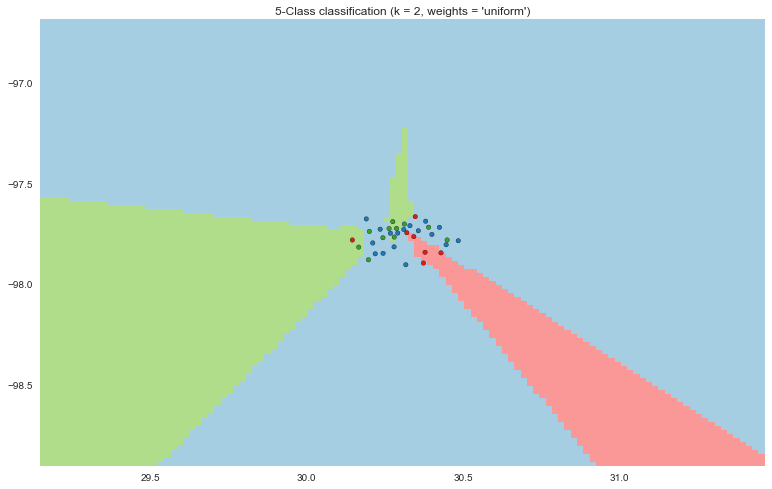

In [78]:
# Plot also the training points
plt.figure(figsize=(13,8))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("5-Class classification (k = %i, weights = '%s')"
         % (2, 'uniform'));

We only got 3 classes when running our KNN algorithm for k=2 (and less classes if we raise k) - this makes sense because we have a very small number of points to classify and they all seem clustered together.

Let us take a step back and remember what are the prerequisites for a successful implementation of the k Nearest Neighbors binary classifier:

* **Density of training data**: you should have roughly the same number of samples for each class. Doesn't need to be exact, but I'd say not more than 10% disparity. Otherwise the boundaries will be very fuzzy.
* **Size of your whole training set**: you need to have sufficiently enough examples in your training set so your model can generalize to unknown samples.
* **Noise**: KNN is very sensitive to noise by nature, so you want to avoid noise in your training set as much as possible.

None of those prerequisites is really satisfied, so choosing a KNN Classifier was a bad idea, save from the nice scatter plot.

### Decision Trees - Random Forests

Going back to our "data" DataFrame, let us now attempt to implement a decision tree as a binary classifier

In [79]:
data.head(3)

,Facility_ID,Restaurant_Name,Inspection_Date,Process_Description,Geocode,Street,City,Zip_Code,Score,Latitude,...,Letter_Grade,Area_NE Austin,Area_NW Austin,Area_SE Austin,Area_SW Austin,Status_Pass,Grade_B,Grade_C,Grade_F,Pristine
0,2801996,Mr. Gatti's #118,2015-12-23,Routine Inspection,"2121 W PARMER LN, AUSTIN, TX 78758",2121 W PARMER LN,AUSTIN,78758,94,30.415649,...,A,0,1,0,0,1,0,0,0,1
1,10385802,Subway,2015-12-23,Routine Inspection,"2501 W PARMER LN, AUSTIN, TX 78758",2501 W PARMER LN,AUSTIN,78758,98,30.418236,...,A,0,1,0,0,1,0,0,0,1
2,2802274,Baskin Robbins,2015-12-23,Routine Inspection,"12407 N MOPAC EXPY, AUSTIN, TX 78758",12407 N MOPAC EXPY,AUSTIN,78758,99,30.417462,...,A,0,1,0,0,1,0,0,0,1


In [80]:
from sklearn import tree

feature_cols = ['Area_NE Austin', 'Area_NW Austin', 'Area_SE Austin', 'Area_SW Austin']

X = data[ feature_cols ].values
y = data['Pristine'].values

clf = tree.DecisionTreeClassifier()
clf.fit(X, y)
y_pred = clf.predict(X)

print "Number of mislabeled points : %d" % (y != y_pred).sum()
print "Classifier score: %d" % clf.score(X, y)

Number of mislabeled points : 6022
Classifier score: 0


In [81]:
len(y)

16113

***We have mislabeled 6022 out of the 16113 points, yet the classifier's score is equal to zero. (?)***

Let us attempt a train/test split and cross-validation:

In [82]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=.25)
clf.set_params(min_samples_leaf=4)
clf.set_params(max_depth=3)
clf.fit(X_train, y_train)

print metrics.confusion_matrix(y_train, clf.predict(X_train))
print metrics.classification_report(y_train, clf.predict(X_train))
print "The score of the Decision Tree classifier on the training data is {0}".format(clf.score(X_train,y_train))
print ""
print metrics.confusion_matrix(y_test, clf.predict(X_test))
print metrics.classification_report(y_test, clf.predict(X_test))
print "The score of the Decision Tree classifier on the test data is {0}".format(clf.score(X_test,y_test))



[[   0 4540]
 [   0 7544]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      4540
          1       0.62      1.00      0.77      7544

avg / total       0.39      0.62      0.48     12084

The score of the Decision Tree classifier on the training data is 0.624296590533

[[   0 1482]
 [   0 2547]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1482
          1       0.63      1.00      0.77      2547

avg / total       0.40      0.63      0.49      4029

The score of the Decision Tree classifier on the test data is 0.632166790767


The zeros in the $[0][0]$ element of the confusion matrix are really bad news: they mean that our tree classifier is really incapable of correctly classifying any true positives (i.e. restaurants passing the health inspection)

We can still try to visualize our tree, which does have some merit due to its 63.2% classification score, but it is becoming more and more evident that this broad area division is a poor feature for our classification purposes.

In [83]:
from sklearn.externals.six import StringIO
with open("pristine.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f, feature_names=feature_cols)

In [84]:
!dot -Tpng pristine.dot > pristine.png

![Pristine Graphviz Plot](pristine.png)

In [86]:
# Even a random forest comprising 250 trees yields the exact same classifier score:

from sklearn.ensemble import RandomForestClassifier

## DecisionTreeClassifier
dtree = tree.DecisionTreeClassifier(max_depth=None, min_samples_split=1,
       random_state=0)
scores = cross_validation.cross_val_score(dtree, X_test, y_test)
print "DecisionTreeClassifier:", scores.mean()

## RandomForestClassifier
forest = RandomForestClassifier(n_estimators=250,
     max_features=4, random_state=0, max_depth=None)
scores = cross_validation.cross_val_score(forest, X_test, y_test)
print "RandomForestClassifier:", scores.mean()

DecisionTreeClassifier: 0.632166790767
RandomForestClassifier: 0.632166790767


Decision Trees and Random Forests give us some interesting information concerning the relative importance of their estimators, and we can visualize those importances:

Feature ranking:
1. feature Area_NE Austin (0.670741452591)
2. feature Area_NW Austin (0.163122826641)
3. feature Area_SE Austin (0.123291877223)
4. feature Area_SW Austin (0.0428438435446)


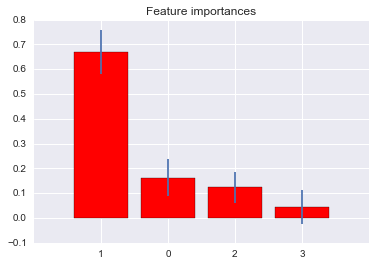

In [87]:
importances = forest.fit(X, y).feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("{0}. feature {1} ({2})".format(f + 1, feature_cols[f], importances[indices[f]]))

# Plot the feature importances of the forest

import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

According to our Random Forest model, the most important feature is a restaurant's location in Northeast Austin. However, given the terrible performance of the classifier in actually finding any passing restaurants, we can safely ignore this result.

### Support Vector Classifier

Our final attempt before we give up trying to classify restaurants given the (ad hoc) area of town they are located in is a support vector machine classifier:

In [88]:
from sklearn import svm

In [95]:
svc = svm.SVC(kernel='linear')

X = data[ feature_cols ].values
y = data['Pristine'].values

svc.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [90]:
from matplotlib.colors import ListedColormap
# Create color maps for 2-class classification problem
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_estimator(estimator, X, y):
    estimator.fit(X, y)
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.axis('tight')
    plt.axis('off')
    plt.tight_layout()

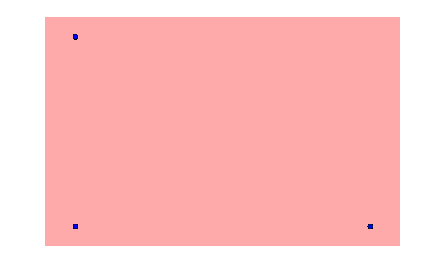

In [92]:
X_ = data[['Area_NW Austin', 'Area_SE Austin']].values # picking two "important" features
y_ = data['Score'].values
plot_estimator(svc, X_, y_)

Visualizing the decision boundaries of our SVC yield a terrible picture, and I assume it is because of the categorical nature of both the features and the output. Let us score it instead:

In [93]:
print X.shape
print y.shape

(16113, 4)
(16113,)


In [96]:
svc.score(X,y)

0.62626450691987834

The support vector classifier yielded a slightly better score when ran on the entire data set. Let us try a train/test split and cross validation to make sure we are not overfitting:

In [100]:
# Cross-validation:

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.8)

In [101]:
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [102]:
print svc.score(X_test, y_test)

0.627055538318


This is a rather respectable score, 62.7%

Interestingly enough, changing the kernel function from 'linear' to 'polynomial' or 'radial' doesn't seem to really affect the classifier's performance. The same applied to changing the *class_weight* parameter to *balanced*.

Remember that even though the Support Vector Classifier has definitely resulted in the most promising classifier (because decision trees and the random forest fail to classify ANY restaurant as "pristine") for our data, the price we have to pay is our model's interpretability, since SVMs are largely "black boxes". Our firm conviction is that Area is not a good predictor of a restaurant's health inspection status, therefore our next attempt will be text mining and using a restaurant's name or the name of the street it is located at as a predictor.

### Next: Supervised Learning - Text Mining for Classification